# Import all Packages

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
### 역자 추가 코드
!pip install timm

In [ ]:
### 역자 추가 코드
import timm

all_models = timm.list_models()
vit_models = [model for model in all_models if 'vit' in model]

# 모델 수 카운트 및 출력
print(f"Total number of ViT models: {len(vit_models)}")
print("Available ViT models in timm:")
for model in vit_models:
    print(model)

Total number of ViT models: 300
Available ViT models in timm:
convit_base
convit_small
convit_tiny
crossvit_9_240
crossvit_9_dagger_240
crossvit_15_240
crossvit_15_dagger_240
crossvit_15_dagger_408
crossvit_18_240
crossvit_18_dagger_240
crossvit_18_dagger_408
crossvit_base_240
crossvit_small_240
crossvit_tiny_240
davit_base
davit_base_fl
davit_giant
davit_huge
davit_huge_fl
davit_large
davit_small
davit_tiny
efficientvit_b0
efficientvit_b1
efficientvit_b2
efficientvit_b3
efficientvit_l1
efficientvit_l2
efficientvit_l3
efficientvit_m0
efficientvit_m1
efficientvit_m2
efficientvit_m3
efficientvit_m4
efficientvit_m5
fastvit_ma36
fastvit_mci0
fastvit_mci1
fastvit_mci2
fastvit_s12
fastvit_sa12
fastvit_sa24
fastvit_sa36
fastvit_t8
fastvit_t12
flexivit_base
flexivit_large
flexivit_small
gcvit_base
gcvit_small
gcvit_tiny
gcvit_xtiny
gcvit_xxtiny
levit_128
levit_128s
levit_192
levit_256
levit_256d
levit_384
levit_384_s8
levit_512
levit_512_s8
levit_512d
levit_conv_128
levit_conv_128s
levit_conv_

# Data Preparation
1. We will be using the model `vit_base_patch16_224`
  * This means all image need to be reshaped to (224,224)
2. In training, we are using data augmentation process: `RandomHorizontalFlip`.
  * It is optional step
  *  It randomly flips an input image horizontally
  * It  artificially increase the size and diversity of the training dataset
3. We also normalizes the image `transforms.Normalize`
  * This will reduce the scale of image
  * It helps on Faster convergence, better generalization, and numercial stability


In [ ]:
### 역자 추가 코드
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 디렉토리는 자신의 구글 드라이브 설정에 맞춰서 변경이 필요합니다.
# 실습 데이터셋(https://www.kaggle.com/datasets/jr2ngb/cataractdataset) 용량은 4GB입니다.
# 이 데이터셋을 구글 드라이브에 폴더당 10개씩의 이미지만 올립니다.
# 축소 데이터셋은 도서의 예제 코드에서 제공합니다.
# 폴더명은 normal, cataract, glaucoma, retina_disease 입니다.

DATA_DIR = "/content/drive/MyDrive/Book6/Ch7/dataset/"
CLASSES = ["normal", "cataract", "glaucoma", "retina_disease"]


data = []
for class_idx, class_name in enumerate(CLASSES):
    class_dir = os.path.join(DATA_DIR, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        data.append([img_path, class_idx])

df = pd.DataFrame(data, columns=["image_path", "label"])
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

class CataractDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

train_dataset = CataractDataset(train_df["image_path"].values,
                                train_df["label"].values,
                                transform=train_transforms)
test_dataset = CataractDataset(test_df["image_path"].values, test_df["label"].values, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)



# Let's review our dataloader
1. We are just viewing the image from train_dataloader
2. There is one very important step:
  * matplotlib need the image in [H, W, C]; where dataloader has image of shape [C, H,W]
  * Thus, before plotting we are transposing so that the data is suitable for viewing for matplotlib

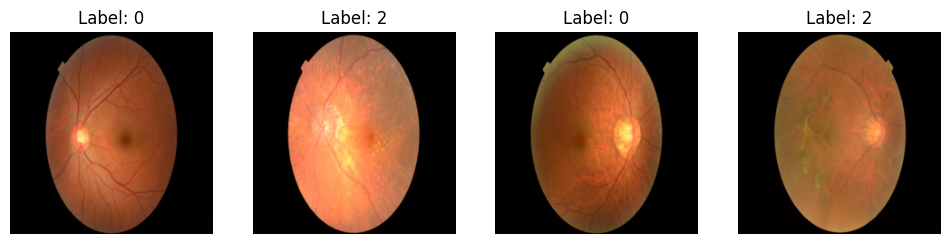

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(train_loader)
images, labels = next(data_iter)

# 역정규화(unnormalize)를 수행해서 텐서 이미지를 넘파이 어레이로 변환
def imshow(img_tensor):
    img = img_tensor.numpy()
    # 트랜스포즈(transpose)
    img = np.transpose(img, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# 이미지와 레이블 디스플레이
fig, axes = plt.subplots(1, len(images), figsize=(12, 12))

for idx, (image, label) in enumerate(zip(images, labels)):
    axes[idx].imshow(imshow(image))
    axes[idx].set_title(f"Label: {label.item()}")
    axes[idx].axis("off")

plt.show()


# Declare the model
1. We are using the pre-trained model from timm
2. If the image is color,
  * in_chans=3;
3. if image is graysclae,
  * in_chans=3=1
4. We need to declare, how many classes we have in out dataset:
  * For our case, it was 4.
  * num_classes=4
5. `pretrained=True`
  * We are mentioning that we want weight of pre-trained model. If you want to train from scratch, you could just mention
    * pretrained=False

In [ ]:
import timm
model = timm.create_model("vit_base_patch16_224", in_chans=3, num_classes=4, pretrained=True)


# Declare the train and test loop
1. In the below code: I am converting output and target into 'cpu'. Somehow my M1 chip is producing the problem. You may not encounter the problem. Thus, this is totally optional step.

In [ ]:
def train(model, device, train_loader, optimizer, criterion, epoch, accelerator):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        accelerator.backward(loss)
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch: {epoch}, Loss: {avg_loss:.4f}")

from sklearn.metrics import confusion_matrix, recall_score, precision_score

def test(model, device, test_loader, criterion, accelerator):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            output_cpu = output.to('cpu')
            target_cpu=target.to('cpu')
            pred = output_cpu.argmax(dim=1, keepdim=True)
            correct += pred.eq(target_cpu.view_as(pred)).sum().item()

            all_preds.extend(pred.flatten().tolist())
            all_targets.extend(target.flatten().tolist())

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # 혼동 행렬(confusion matrix), 리콜(sensitivity) 및 specificity 계산
    cm = confusion_matrix(all_targets, all_preds)
    sensitivity = recall_score(all_targets, all_preds, average=None)
    specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)

    for i, (sens, spec) in enumerate(zip(sensitivity, specificity)):
        print(f"Class {i}: Sensitivity (Recall): {sens:.4f}, Specificity: {spec:.4f}")



In [ ]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device
learning_rate = 1e-4

optimizer = Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_loader, test_loader = accelerator.prepare(train_loader, test_loader)
model, optimizer, criterion = accelerator.prepare(model, optimizer, criterion)



In [ ]:
# 런타임 1분 이하
# 역자 주: 실행 시간을 줄이기 위해 num_epochs를 10으로 줄임
# num_epochs = 50
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, criterion, epoch, accelerator)
    test(model, device, test_loader, criterion, accelerator)

100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


Epoch: 1, Loss: 1.9479


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.1298, Accuracy: 33.33%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 1.0000, Specificity: 0.6667
Class 2: Sensitivity (Recall): 0.0000, Specificity: nan


100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


Epoch: 2, Loss: 1.4107


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.1096, Accuracy: 33.33%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.6667
Class 1: Sensitivity (Recall): 0.0000, Specificity: nan
Class 2: Sensitivity (Recall): 0.0000, Specificity: nan


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Epoch: 3, Loss: 1.3083


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.1021, Accuracy: 33.33%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 0.0000, Specificity: nan
Class 2: Sensitivity (Recall): 1.0000, Specificity: 0.6667


100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


Epoch: 4, Loss: 1.1746


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.0121, Accuracy: 50.00%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.5000
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.5000
Class 2: Sensitivity (Recall): 0.0000, Specificity: nan


100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


Epoch: 5, Loss: 1.0760


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.0717, Accuracy: 66.67%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.3333
Class 1: Sensitivity (Recall): 0.0000, Specificity: nan
Class 2: Sensitivity (Recall): 1.0000, Specificity: 0.3333


100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


Epoch: 6, Loss: 1.1419


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 0.8993, Accuracy: 50.00%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.3333
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.6667
Class 2: Sensitivity (Recall): 0.0000, Specificity: nan


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Epoch: 7, Loss: 1.1179


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.1360, Accuracy: 33.33%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.6667
Class 1: Sensitivity (Recall): 0.0000, Specificity: nan
Class 2: Sensitivity (Recall): 0.0000, Specificity: nan


100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


Epoch: 8, Loss: 1.1375


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.0059, Accuracy: 66.67%
Class 0: Sensitivity (Recall): 0.0000, Specificity: nan
Class 1: Sensitivity (Recall): 1.0000, Specificity: 0.3333
Class 2: Sensitivity (Recall): 1.0000, Specificity: 0.3333


100%|██████████| 6/6 [00:03<00:00,  1.64it/s]


Epoch: 9, Loss: 1.0474


<ipython-input-16-bde4420312d5>:46: RuntimeWarning: invalid value encountered in divide
  specificity = (cm.sum(axis=0) - cm.diagonal()) / cm.sum(axis=0)


Test Loss: 1.0133, Accuracy: 66.67%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.3333
Class 1: Sensitivity (Recall): 0.0000, Specificity: nan
Class 2: Sensitivity (Recall): 1.0000, Specificity: 0.3333


100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


Epoch: 10, Loss: 1.0467
Test Loss: 0.9514, Accuracy: 66.67%
Class 0: Sensitivity (Recall): 1.0000, Specificity: 0.3333
Class 1: Sensitivity (Recall): 0.5000, Specificity: 0.5000
Class 2: Sensitivity (Recall): 0.5000, Specificity: 0.0000


# Analysis:
1. The loss is decreasing. We need more epoch.

In [ ]:
# 역자 주: 위의 코멘트와 함께 저자의 코드는 끝을 맺습니다.